In [1]:
from sklearn import datasets
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math
from numpy import linalg
#from scipy import optimize
import pandas as pd
import matplotlib as mpl

In [49]:
# Main Variables
plotting_on = 1
mask_plotting = 1
cluster_size = 2
noise_threshold = 10.0
S = 1
sample_size = 49
cluster_size = 2

spill_over = False
spill_over_idx = []

In [60]:
from scipy.spatial import distance

def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1, endpoint=False),
               np.linspace(p1[1], p2[1], parts+1, endpoint=False))

def estimate_epsilon(X, labels):
    # Get the number of clusters
    num_clusters = len(set(labels))-1 # Noisy samples are given the label -1

    # For more than one cluster
    est_eps = []
    clusters = {}
    for i in range(num_clusters):
        cluster_i = {}
        for idx, label in enumerate(labels):
            if label == i:
                cluster_i[idx] = X[idx]
        clusters[i] = cluster_i
    for key in clusters.keys():
        print("Cluster", key)
        node = list(clusters[key].values())
        print("------------------------------node------------------------------")
        longest_dis = [] # Lower bound
        for i in range(len(node)):
            longest_dis.append(distance.cdist([node[i]], node[:i]+node[i+1:]).min())
        max_gap = max(longest_dis)
        print("Lower bound: ", longest_dis)
        print("Max is", max(longest_dis)) # The biggest gap between points in each cluster
        print("Average is: ", sum(longest_dis)/len(longest_dis))
        est_eps.append(max_gap)

    return max(est_eps)

def run_dbscans(epsilon, min_sample, X):    
    db_model = DBSCAN(eps = epsilon, min_samples = min_sam)
    db_pre = db_model.fit(X)
    clusters = db_pre.labels_
    plt.scatter(X[:, 0], X[:, 1], c=clusters)
    num_clusters = len(set(clusters))-1 # Noisy samples are given the label -1.
    return clusters, num_clusters

In [69]:
from scipy.spatial import distance
import scipy.spatial as spatial
from numpy import ones,vstack
from numpy.linalg import lstsq

def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1, endpoint=False),
               np.linspace(p1[1], p2[1], parts+1, endpoint=False))

def closest_node(cluster_1, cluster_2):
    node = list(cluster_1.values())
    nodes = list(cluster_2.values())
    closest_dis = distance.cdist(node, nodes)
    ri, ci = closest_dis.argmin()//closest_dis.shape[1], closest_dis.argmin()%closest_dis.shape[1]# index of the node and nodes
    closest_distance = closest_dis[ri][ci]
    
    # Closest distance that bigger than T
    limit = epsilon
    # Way 1
    index = np.ma.argmin(np.ma.masked_less(closest_dis, limit))
    # # Way 2
    # valid_idx = np.where(closest_dis.flatten() > limit)[0]
    # out = valid_idx[closest_dis.flatten()[valid_idx].argmin()]
    rj, cj = index//closest_dis.shape[1], index%closest_dis.shape[1]
    pair = node[rj], nodes[cj]
    return closest_distance, pair

def GetMedoid(vX):
  vMean = np.mean(vX, axis=0)
  vMedoid = vX[np.argmin([sum((x - vMean)**2) for x in vX])]
  return vMean

def nearest_neighbours(tup):
    smallest_dist = None
    first = None
    second = None
    for i in range(len(tup)-1): # based on key 
        key_i = list(tup.keys())[i]
        for j in range(i+1, len(tup)): # based on key
            key_j = list(tup.keys())[j]
            dist = (tup[i][0]-tup[j][0])**2 + (tup[i][1]-tup[j][1])**2
            if smallest_dist is None or dist < smallest_dist:
                smallest_dist = dist
                first = key_i
                second = key_j
    return first, second


def merge_two(X, labels):
    # variables
    cenroids = {}

    order = list(set(labels))
    out = {k:[] for k in order}
    for key, value in zip(labels, X):
        out[key].append(value)
    
    out.pop(-1)
    print(out)

    # Get the cenroids of all clusters
    for k in out.keys():
        cenroid = GetMedoid(out[k])
        cenroids[k] = cenroid
         
    print(cenroids)

    # looking for the closest two and get the labels
    first, second = nearest_neighbours(cenroids)

    # return the closest two clusters labels
    print("The two clusters to merge are {}, {}. ".format(first, second))
    return first, second
    

# Add merged data to fool dbscan
# Only work for two clusters
def db_merge(X, labels):
    # Variables
    epsilon = estimate_epsilon(X, labels)
    print("Estimated epsilon is ", epsilon)

    # When there more than one clusters
    # Start with the closest diff of means between clusters
    
    first, second = merge_two(X, labels)

    # Step 1: Finding the closest two points in the two clusters to determine the start and target points
    chosen_pts_cluster_label = []
    cluster_1 = {}
    cluster_2 = {}
    for idx, label in enumerate(labels):
        if label == first:
            cluster_1[idx] = X[idx]
        elif label == second:
            cluster_2[idx] = X[idx]
    
    closest_distance, closest_pair = closest_node(cluster_1, cluster_2)    
    print("The closest distance is: ", closest_distance)

    # Step 2: Report their distance and generate data mines fall into the range of T - epsilon
    X_noisy = np.copy(X)
    Ax = closest_pair[0][0]
    Ay = closest_pair[0][1]
    Bx = closest_pair[1][0]
    By = closest_pair[1][1]
    num_noisy = math.ceil(closest_distance / epsilon)
    noisy=list(getEquidistantPoints((Ax,Ay), (Bx, By), num_noisy))
    X_noisy = np.vstack([X_noisy, noisy[1:]]) # Add the noist points in
    # Find the slope m
    x_coords, y_coords = zip(*noisy)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
    #print("Line Solution is y = {m}x + {c}".format(m=m,c=c))

    # Step3: Generate data mines meet the min-samples - epsilon 
    # Here when the density comes 
    # point_tree = spatial.cKDTree(X_noisy)
    # noisy_2 = []
    # for target in noisy:
    #     # Find the number of neighbours of points fall in range of T
    #     num_neighbour = point_tree.query_ball_point(target, epsilon)
    #     # for n in num_neighbour:
    #     #     print("Neighbour: ", X_noisy[n])
    #     #     #Insert at the boundary of T
    #     num_noisy_min = min_sam - len(num_neighbour)
    #     for j in range(num_noisy_min):
    #         # to the left
    #         new_x = target[0] - (epsilon / (math.sqrt((1+m*m))))
    #         new_y = m*new_x + c
    #         noisy_2.append((new_x, new_y))
    #     num_noisy += num_noisy_min
    
    #print(noisy_2)
    X_noisy = np.vstack([X_noisy, noisy]) # Add the noist points in     
        
    # Step 4: Modify the dataset to move existing data to the data mines positions


    # Summary:
    clusters, num_clusters = run_dbscans(epsilon, min_sam, X_noisy)
    print("The number of points we generate are: ", num_noisy)

    return X_noisy, clusters, num_clusters, num_noisy

In [78]:
def main(X, clusters):
    num_clusters = len(set(clusters))-1 # Noisy samples are given the label -1.
    # When there are more than 2 clusters, keep merging the clusters until a single cluster is formed
    # ? Take the mean/median and find the closeet diff
    i = 1
    performances = 0
    while num_clusters > 1:
        print("Iteration: ", i)
        X, clusters, num_clusters, performance = db_merge(X, clusters)
        performances += performance
        i += 1
    # Optimising function is check the order of iterations - the mean/median - NOT YET DONE
    print("----------------------------Evaluation----------------------------")
    print("The total number of points for {} iterations we generated are {}".format(i-1, performances))

(100, 2)


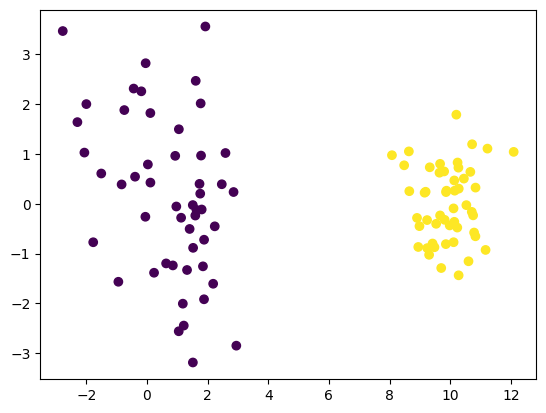

In [81]:
# Test 1
# Create the data
data = datasets.make_blobs(n_samples=sample_size, cluster_std=[1.45,0.75], random_state=170, centers = [[1,0],[10,0]])
X = data[0]
y = data[1]
print(X.shape)
a = plt.scatter(X[:, 0], X[:, 1], c=y)

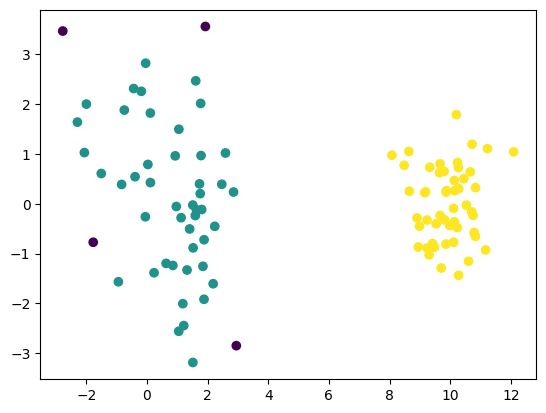

In [82]:
# Test 1
# Compute DBSCAN
# eplison is the radius of a particular point's neighbourhood circle which determines the cluster
# min-sample is minimum size of the cluster

epsilon = 1.32
min_sam = 5

db_model = DBSCAN(eps = epsilon, min_samples = min_sam)
db_pre = db_model.fit(X)
clusters = db_pre.labels_
plt.scatter(X[:, 0], X[:, 1], c=clusters)

Iteration:  1
Cluster 0
------------------------------node------------------------------
Lower bound:  [0.11889617017441176, 0.4850938160465538, 0.15601113725803664, 0.11889617017441176, 0.46962351967322064, 0.4818453569617863, 0.7057679753363769, 0.4181975057789348, 0.5470976648663668, 0.20133711090469114, 0.46674661403383905, 0.3965836398862971, 0.19790007932051742, 0.46962351967322064, 0.2753013101665758, 0.22561753092631184, 0.6968098424114025, 0.4818453569617863, 0.5699160122509955, 0.6534403159839004, 0.6383811460843758, 0.44070507918698143, 0.43334473340061413, 0.3735247113827025, 0.20133711090469114, 0.395939426330903, 0.17155166719899886, 0.5283738739468635, 0.22561753092631184, 0.46674661403383905, 0.4397475284886067, 0.2753013101665758, 0.3735247113827025, 0.4181975057789348, 0.7807844843290961, 0.4764745068869037, 0.2582384024343493, 0.2582384024343493, 0.5816114410637158, 0.19790007932051742, 0.32772077480742445, 0.5470976648663668, 0.43334473340061413, 1.189893208278928, 

c:\Users\samch\OneDrive\Desktop\Sam\uoa\compsci789\venv\lib\site-packages\ipykernel_launcher.py:113: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


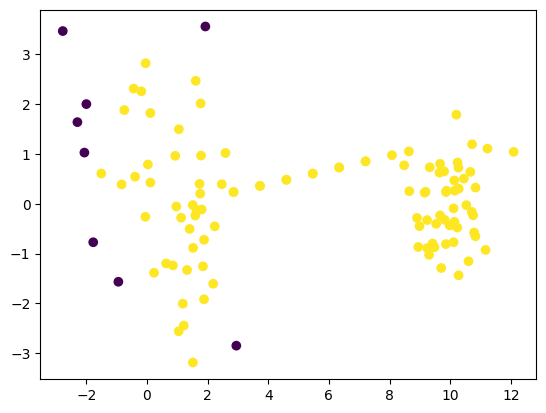

In [83]:
# Test 1 - Run
# Everything starts here
main(X, clusters)

(100, 2)


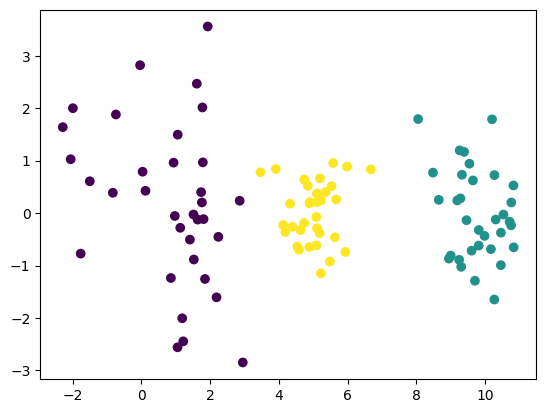

In [66]:
# Test 2
# Create the data
sample_size = 100
data = datasets.make_blobs(n_samples=sample_size, cluster_std=[1.45,0.75, 0.6], random_state=170, centers = [[1,0],[10,0], [5,0]])
X = data[0]
y = data[1]
print(X.shape)
a = plt.scatter(X[:, 0], X[:, 1], c=y)

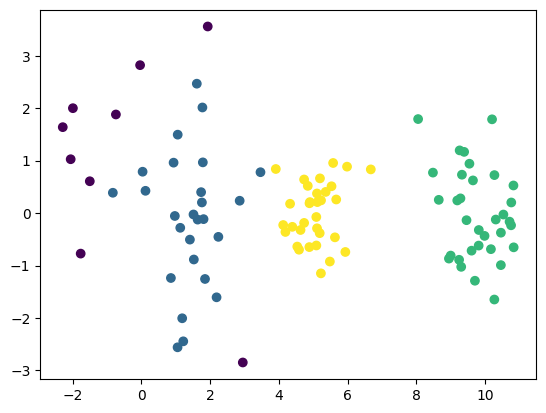

In [67]:
# Test 2 
# Compute DBSCAN
# eplison is the radius of a particular point's neighbourhood circle which determines the cluster
# min-sample is minimum size of the cluster

epsilon = 1.2
min_sam = 5

db_model = DBSCAN(eps = epsilon, min_samples = min_sam)
db_pre = db_model.fit(X)
clusters = db_pre.labels_
plt.scatter(X[:, 0], X[:, 1], c=clusters)
num_clusters = len(set(clusters))-1 # Noisy samples are given the label -1.


Iteration:  1
Cluster 0
------------------------------node------------------------------
Lower bound:  [0.15601113725803664, 0.4850938160465538, 0.15601113725803664, 0.950417741448838, 0.4818453569617863, 0.5470976648663668, 0.20133711090469114, 0.19790007932051742, 0.8141182274488786, 0.2753013101665758, 0.7551185676810335, 0.4818453569617863, 0.5699160122509955, 0.44070507918698143, 0.3735247113827025, 0.20133711090469114, 0.395939426330903, 0.17155166719899886, 0.2753013101665758, 0.3735247113827025, 0.8141182274488786, 0.19790007932051742, 0.3598802404739016, 0.5470976648663668, 0.4850938160465538, 0.5478606842536785]
Max is 0.950417741448838
Average is:  0.4329172402899057
Cluster 1
------------------------------node------------------------------
Lower bound:  [0.0822767628340526, 0.24159511348127544, 0.0822767628340526, 0.22433019226212153, 0.14791123789162405, 0.4039699787273945, 0.3247920912614228, 0.33436739862852133, 0.2920510809791197, 0.10118704235323239, 0.1479112378916240

c:\Users\samch\OneDrive\Desktop\Sam\uoa\compsci789\venv\lib\site-packages\ipykernel_launcher.py:113: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
c:\Users\samch\OneDrive\Desktop\Sam\uoa\compsci789\venv\lib\site-packages\ipykernel_launcher.py:113: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


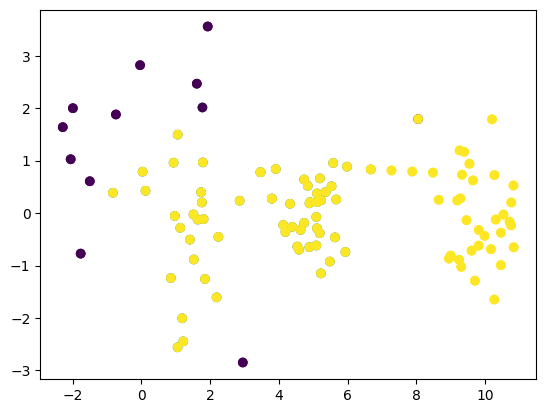

In [79]:
# Test 2 - Run
# Everything starts here
main(X, clusters)